In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [150]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["ytick.minor.size"] = 1.0
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["ytick.minor.width"] = 0.18

plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## DN screen

In [59]:
simType = "DN_Screen"
simPath = simType+"/hyak/run_id=28340113"
folder = dataPath + simPath

params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1],index_col=0)
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
neuronParams = h5py.File(folder+"/ckpt/neuron_params.h5","r")

# Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
# params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

# dataset = 0
# Rs = Rs[dataset]
# nSims = Rs.shape[0]
# Rs.shape

Rs_batch = sparse.load_npz(folder+f"/ckpt/checkpoints/results_final/Final_batch_Rs_0.npz").todense()
Rs_batch.shape

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


(256, 4604, 1001)

In [64]:
neuronParams["input_currents"].shape[1]

16

In [95]:
inputs = neuronParams["input_currents"]
nDns = inputs.shape[0]
nReps = inputs.shape[1]
scores = np.zeros((nDns,nReps))
nActive = np.zeros((nDns,nReps))
# nMnsActive = np.zeros((nDns,nReps))
dnIdxList = []

nrnNo = 0
for batch in range(59):
    Rs_batch = sparse.load_npz(folder+f"/ckpt/checkpoints/results_final/Final_batch_Rs_{batch}.npz").todense()
    for nrn in range(int(len(Rs_batch)/nReps)):
        dnIdxList += np.where(inputs[nrnNo].sum(0)>0)[0].tolist()
        for rep in range(nReps):
            R = Rs_batch[nrn*nReps+rep]
            activeMask = np.max(R,1)>0.01
            nActive[nrnNo,rep] = np.sum(activeMask)
            # activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
            # nMnsActive[nrnNo,rep] = np.sum(activeMnsMask)
            activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
            score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
            scores[nrnNo,rep] = score
        nrnNo += 1

In [96]:
scoreSummary = pd.DataFrame(scores,index=dnIdxList)
scoreSummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4599,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4600,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
activitySummary = pd.DataFrame(nActive,index=dnIdxList)
activitySummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,5.0,6.0,33.0,5.0,23.0,5.0,5.0,5.0,7.0,11.0,5.0,23.0,31.0,9.0,5.0,6.0
1,16.0,11.0,22.0,19.0,18.0,14.0,19.0,22.0,17.0,21.0,17.0,17.0,14.0,15.0,14.0,5.0
3,57.0,64.0,328.0,7.0,112.0,294.0,82.0,5.0,55.0,59.0,9.0,46.0,7.0,5.0,5.0,6.0
7,10.0,20.0,18.0,9.0,21.0,16.0,19.0,20.0,20.0,10.0,16.0,17.0,9.0,17.0,10.0,10.0
20,14.0,2.0,15.0,11.0,11.0,13.0,14.0,5.0,10.0,13.0,15.0,10.0,12.0,4.0,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,3.0,3.0,4604.0,3.0,4604.0,3.0,4604.0,3.0,3.0,4604.0,3.0,4604.0,3.0,3.0,3.0,3.0
4599,5.0,3.0,5.0,5.0,7.0,4.0,5.0,10.0,5.0,3.0,3.0,5.0,5.0,5.0,3.0,4.0
4600,169.0,195.0,197.0,174.0,183.0,188.0,185.0,188.0,180.0,14.0,173.0,192.0,164.0,189.0,183.0,10.0
4601,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


In [101]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
scoreSummary.to_csv(figFolder+"/scoreSummary.csv")
activitySummary.to_csv(figFolder+"/activitySummary.csv")

In [114]:
usableScores = scores.copy()
usableScores[nActive<5]=np.nan
usableScores[nActive>500]=np.nan
usableScoreSummary = pd.DataFrame(usableScores,index=dnIdxList)
usableScoreSummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4600,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
usableScoreSummary["mean"] = usableScoreSummary.mean(1,skipna=True)
usableScoreSummary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109138
7,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
20,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.000000
4600,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002302
4601,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [118]:
usableScoreSummary.insert(0,"bodyId",usableScoreSummary.index.map(dict(zip(wTable.index,wTable["bodyId"]))))
usableScoreSummary

,bodyId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
0,10000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,10002,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,10012,0.0,0.000000,0.334372,0.0,0.97181,0.440032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109138
7,10021,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
20,10061,0.0,NaN,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,51939777929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,53202877530,0.0,NaN,0.000000,0.0,0.00000,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.000000
4600,53581075416,0.0,0.036825,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002302
4601,53588309438,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [119]:
usableScoreSummary.sort_values("mean",ascending=False)

,bodyId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean
132,10339,0.998818,0.989875,0.995873,1.000211,0.998084,0.973427,0.973243,0.996819,1.002357,0.997735,1.002506,0.889716,0.997364,0.999523,0.931903,0.987328,0.983424
31,10093,0.936705,0.891175,0.997490,1.000043,0.996282,1.000092,1.001227,0.995574,0.931632,0.995963,0.950768,0.999098,0.998793,0.996960,0.998782,0.967047,0.978602
1211,14061,0.993952,NaN,0.997660,0.968734,NaN,0.985149,0.963076,0.991625,0.994045,NaN,NaN,0.706906,0.995877,0.925064,0.957911,0.983032,0.955253
3602,30919,0.918934,0.843272,0.944500,0.756300,0.834266,0.885887,0.778689,0.998175,0.999247,0.908585,0.975560,0.775671,0.990972,0.944558,0.960339,0.974609,0.905598
2048,18279,0.864892,0.995580,0.851715,0.930740,0.891598,0.845125,0.884371,0.847077,0.847809,0.971836,0.389601,0.972363,0.956787,0.899060,0.967105,0.737755,0.865838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,153153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4473,163639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,163893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4512,166522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
sum(usableScoreSummary["mean"].notna())

749

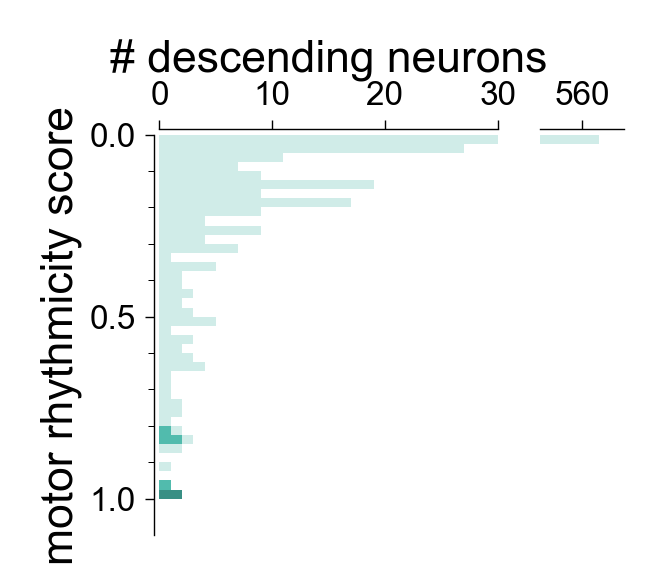

In [157]:
fig,ax = plt.subplots(1,2,width_ratios=[4,1])#,sharex=True)

sns.histplot(y=usableScoreSummary["mean"].dropna(),bins=np.arange(0,1.1,0.025),color="#d0ece8ff",edgecolor="None",ax=ax[0],alpha=1,zorder=-1)
sns.histplot(y=usableScoreSummary.loc[usableScoreSummary.index.isin(wTable.loc[wTable["type"]=="DNb08"].index),"mean"],
             bins=np.arange(0,1.1,0.025),color="#51bbad",edgecolor="None",ax=ax[0],alpha=1,zorder=1)
sns.histplot(y=usableScoreSummary.loc[usableScoreSummary.index.isin(wTable.loc[wTable["type"]=="DNg100"].index),"mean"],
             bins=np.arange(0,1.1,0.025),color="#388f84ff",edgecolor="None",ax=ax[0],alpha=1,zorder=1)
ax[0].set_xlabel("# descending neurons")
ax[0].xaxis.set_label_position("top")
ax[0].set_ylabel("motor rhythmicity score")
ax[0].set_xticks(np.arange(0,31,10))
ax[0].set_yticks(np.arange(0,1.1,0.5))
ax[0].set_yticks(np.arange(0,1.1,0.1),minor=True)
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0,30])
ax[0].invert_yaxis()

sns.histplot(y=usableScoreSummary["mean"].dropna(),bins=np.arange(0,1.1,0.025),color="#d0ece8ff",edgecolor="None",ax=ax[1],alpha=1)
ax[1].invert_yaxis()
ax[1].set_xlabel("")
ax[1].set_xticks([560,570])
ax[1].set_xlim([555,565])
ax[1].set_ylim([1.1,0])
ax[1].set_yticks([])
ax[1].set_ylabel("")

sns.despine(offset=1,ax=ax[0],top=False,bottom=True)
sns.despine(offset=1,ax=ax[1],top=False,bottom=True,left=True)
ax[0].xaxis.tick_top()
ax[1].xaxis.tick_top()

fig.set_dpi(400)

fig.set_figheight(1.3)
fig.set_figwidth(1.5)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/dnScoresHist.svg",transparent=True)
plt.show()